## Business Understanding

### Objective
The objective of this project is to forecast Apple Inc. (AAPL) stock prices
for the next 30 days to support investors, traders, and financial analysts
in making buy/sell decisions.

### Target Variable
- stock_price

### Predictor Variables
- Market Indices: nasdaq_index, sp500_index
- Macroeconomic Indicators: inflation_rate, unemployment_rate, interest_rate
- Market Sentiment: market_sentiment

### Constraints
- Only U.S. market trading hours (4:00 AM – 8:00 PM ET)
- Exclude Saturdays and Sundays
- Do not drop rows for missing values or outliers


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings("ignore")


In [2]:
file_path = "Apples_stock_price_dataset[1].xlsx"
df = pd.read_excel(file_path)

df.head()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 00:00:00,102.483571,7984.160950,2994.240923,4.585202,6.837412,1.175768,0.095094
1,2010-01-01 01:00:00,99.347236,7995.706186,2995.831788,2.628987,5.851430,1.918567,-0.241960
2,2010-01-01 02:00:00,103.315558,8000.887651,2998.119650,2.616145,6.235115,2.436716,-0.833554
3,2010-01-01 03:00:00,107.730823,7995.763963,3004.532651,3.115002,6.397255,2.369055,0.059836
4,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077


In [3]:
# Shape
df.shape


(100000, 8)

In [4]:
# Column names
df.columns.tolist()


['timestamp',
 'stock_price',
 'nasdaq_index',
 'sp500_index',
 'inflation_rate',
 'unemployment_rate',
 'interest_rate',
 'market_sentiment']

In [5]:
# Data types & nulls
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          100000 non-null  datetime64[ns]
 1   stock_price        99969 non-null   float64       
 2   nasdaq_index       99993 non-null   float64       
 3   sp500_index        99996 non-null   float64       
 4   inflation_rate     99992 non-null   float64       
 5   unemployment_rate  99996 non-null   float64       
 6   interest_rate      99998 non-null   float64       
 7   market_sentiment   99996 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.1 MB


In [6]:
# Data quality checks after setting timestamp as index

print("Duplicate rows:", df.duplicated().sum())
print("Unique timestamps:", df.index.is_unique)

# Time gap inspection
df.index.to_series().diff().value_counts().head()


Duplicate rows: 0
Unique timestamps: True


1.0    99999
Name: count, dtype: int64

In [7]:
# Statistical summary
df.describe().T


,count,mean,min,25%,50%,75%,max,std
timestamp,100000,2015-09-15 07:30:00,2010-01-01 00:00:00,2012-11-07 15:45:00,2015-09-15 07:30:00,2018-07-22 23:15:00,2021-05-29 15:00:00,NaN
stock_price,99969.0,299.991904,9.537676,248.619582,300.071948,351.442877,601.664858,91.443363
nasdaq_index,99993.0,259114.622519,7984.16095,134716.834762,257861.008478,385205.57814,507957.788157,144514.371806
sp500_index,99996.0,101463.085069,2981.778422,51573.589744,100923.141212,151634.820165,200815.813093,57294.51388
inflation_rate,99992.0,3.004255,1.000002,2.005934,3.005833,4.001412,4.999993,1.152769
unemployment_rate,99996.0,4.996003,3.000021,3.999036,4.990133,5.994514,6.999958,1.154703
interest_rate,99998.0,2.001474,0.500135,1.254851,2.000173,2.750588,3.499985,0.864929
market_sentiment,99996.0,0.003208,-0.99999,-0.498332,0.004348,0.504524,0.999986,0.578063


In [8]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create time features
df['time'] = df['timestamp'].dt.time
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Mon=0, Sun=6
df['hour'] = df['timestamp'].dt.hour

df.head()


,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment,time,day_of_week,hour
0,2010-01-01 00:00:00,102.483571,7984.160950,2994.240923,4.585202,6.837412,1.175768,0.095094,00:00:00,4,0
1,2010-01-01 01:00:00,99.347236,7995.706186,2995.831788,2.628987,5.851430,1.918567,-0.241960,01:00:00,4,1
2,2010-01-01 02:00:00,103.315558,8000.887651,2998.119650,2.616145,6.235115,2.436716,-0.833554,02:00:00,4,2
3,2010-01-01 03:00:00,107.730823,7995.763963,3004.532651,3.115002,6.397255,2.369055,0.059836,03:00:00,4,3
4,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077,04:00:00,4,4


In [9]:
df = df[df['day_of_week'] < 5]


In [10]:
market_start = time(4, 0)
market_end = time(20, 0)

df = df[(df['time'] >= market_start) & (df['time'] <= market_end)]


In [11]:
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)


In [12]:
df.shape

(50592, 10)

In [13]:
# Count missing
df.isnull().sum()


stock_price          18
nasdaq_index          4
sp500_index           3
inflation_rate        4
unemployment_rate     4
interest_rate         0
market_sentiment      0
time                  0
day_of_week           0
hour                  0
dtype: int64

In [14]:
# Percentage missing
(df.isnull().mean() * 100).sort_values(ascending=False)


stock_price          0.035579
nasdaq_index         0.007906
inflation_rate       0.007906
unemployment_rate    0.007906
sp500_index          0.005930
interest_rate        0.000000
market_sentiment     0.000000
time                 0.000000
day_of_week          0.000000
hour                 0.000000
dtype: float64

In [15]:
financial_cols = [
    'stock_price', 'nasdaq_index', 'sp500_index',
    'inflation_rate', 'unemployment_rate', 'interest_rate'
]

# Forward fill for financial continuity
df[financial_cols] = df[financial_cols].fillna(method='ffill')

# Market sentiment smoothing
df['market_sentiment'] = df['market_sentiment'].fillna(
    df['market_sentiment'].rolling(window=5, min_periods=1).mean()
)

df.isnull().sum()


stock_price          0
nasdaq_index         0
sp500_index          0
inflation_rate       0
unemployment_rate    0
interest_rate        0
market_sentiment     0
time                 0
day_of_week          0
hour                 0
dtype: int64

In [16]:
numeric_cols = [
    'stock_price',
    'nasdaq_index',
    'sp500_index',
    'inflation_rate',
    'unemployment_rate',
    'interest_rate',
    'market_sentiment'
]


## Outlier Analysis

Outliers are identified using boxplots and treated using IQR-based capping
to retain all observations while reducing the impact of extreme values.


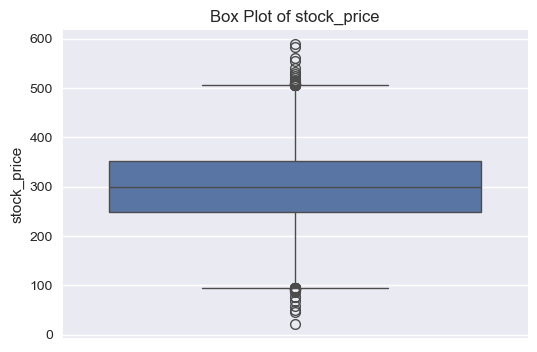

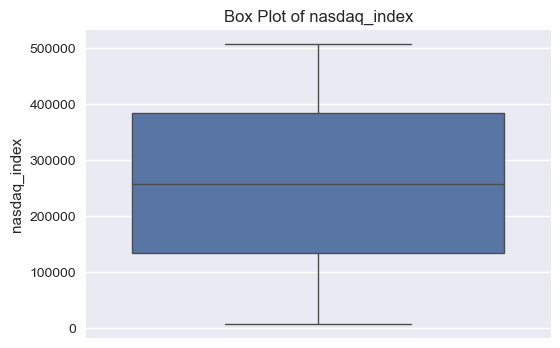

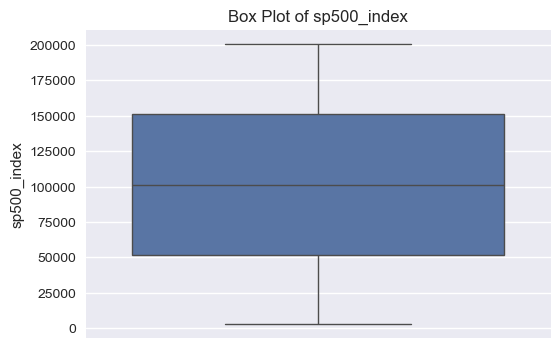

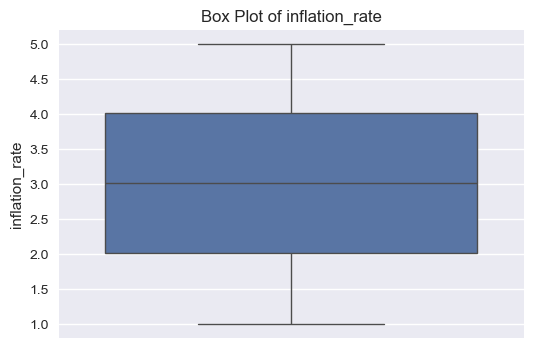

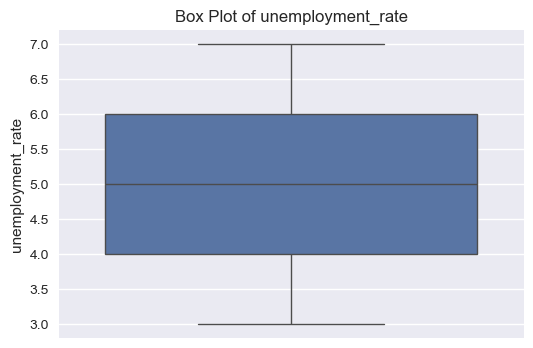

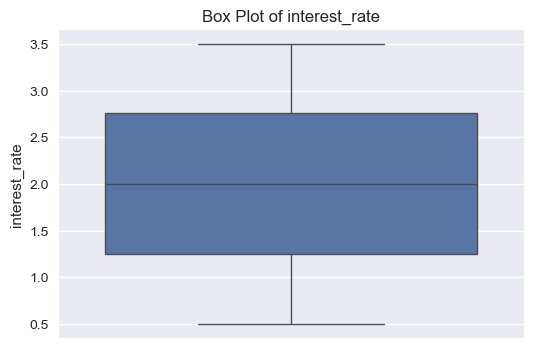

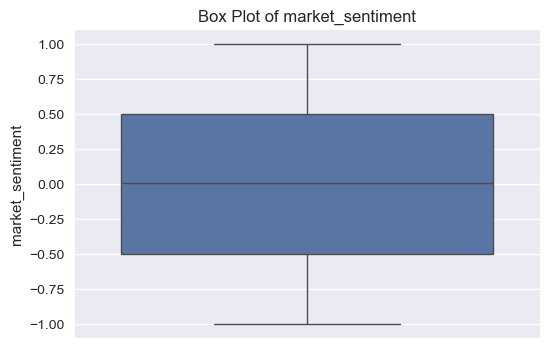

In [17]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot of {col}")
    plt.ylabel(col)
    plt.show()


In [18]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = cap_outliers(df[col])


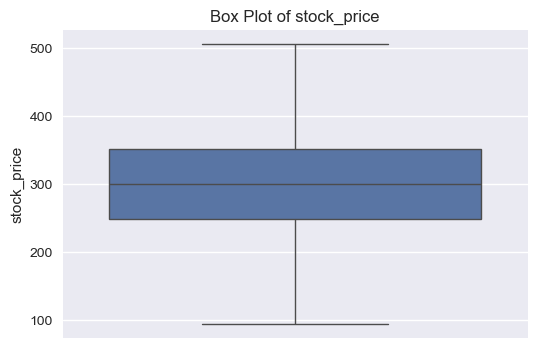

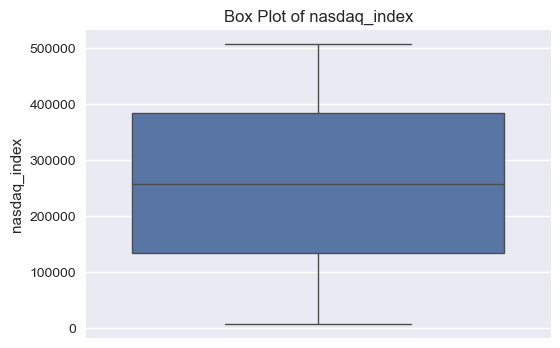

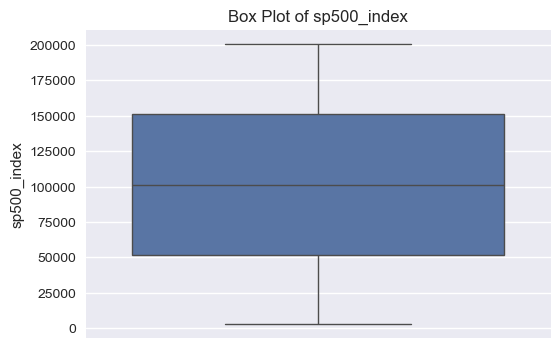

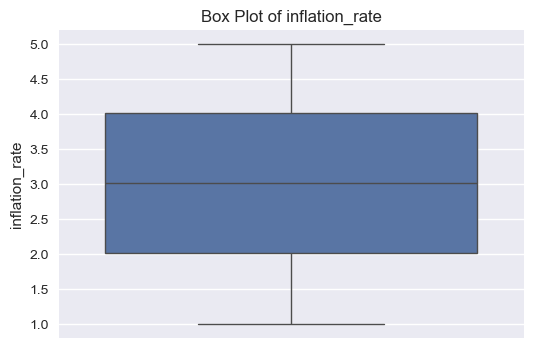

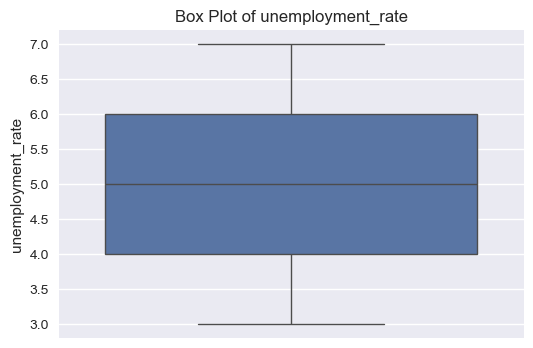

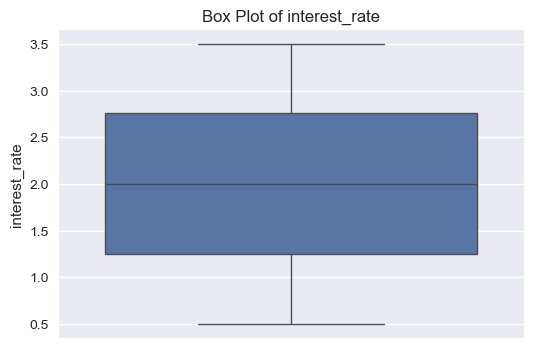

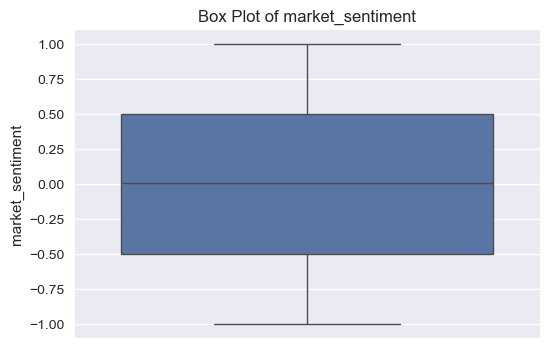

In [19]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot of {col}")
    plt.ylabel(col)
    plt.show()

## Distribution Analysis

Distribution plots help understand the spread, skewness, and variability
of each numerical feature.


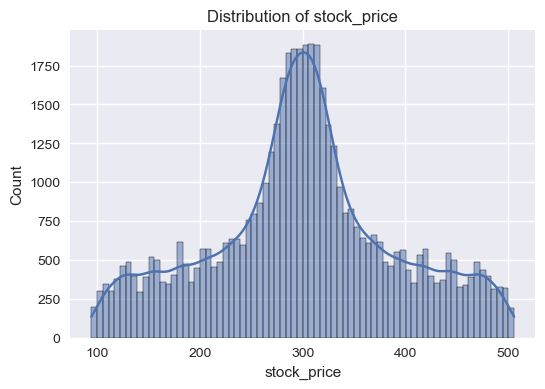

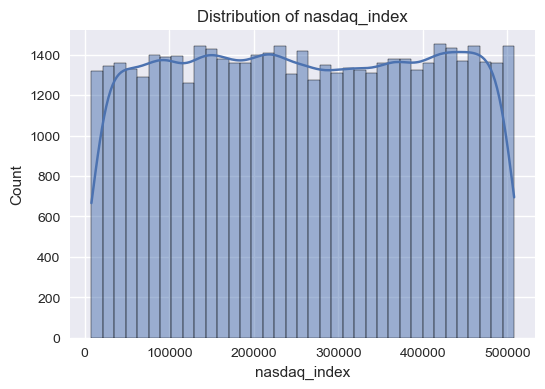

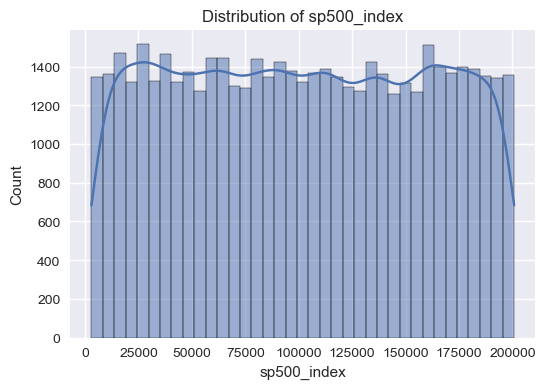

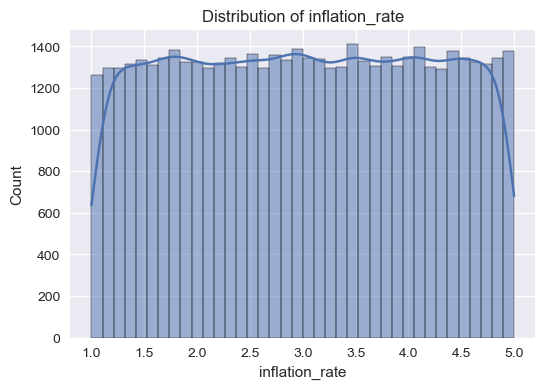

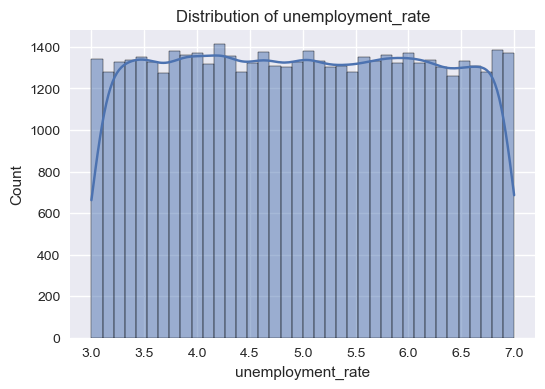

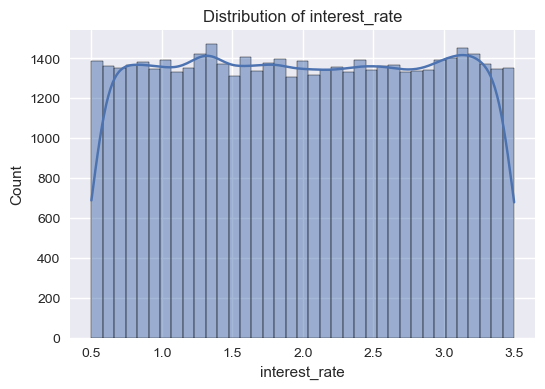

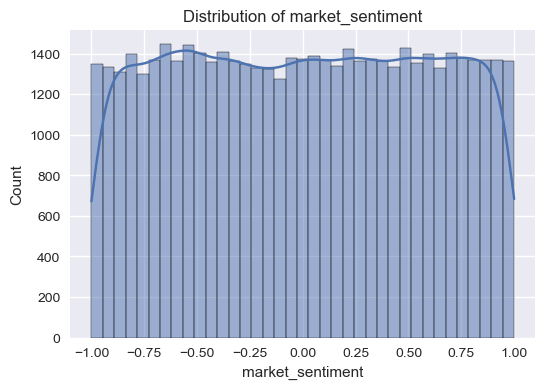

In [20]:
numeric_cols = [
    'stock_price', 'nasdaq_index', 'sp500_index',
    'inflation_rate', 'unemployment_rate',
    'interest_rate', 'market_sentiment'
]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [21]:
skew_kurt = pd.DataFrame({
    'Skewness': df[numeric_cols].skew(),
    'Kurtosis': df[numeric_cols].kurtosis()
})

skew_kurt


,Skewness,Kurtosis
stock_price,0.001630,-0.284535
nasdaq_index,-0.001164,-1.207443
sp500_index,0.011740,-1.210837
inflation_rate,-0.004375,-1.196074
unemployment_rate,0.007355,-1.197578
interest_rate,0.001695,-1.208244
market_sentiment,-0.000947,-1.204744


 Several variables show skewness and excess kurtosis, indicating that
transformations (log/differencing) may be required for certain models.


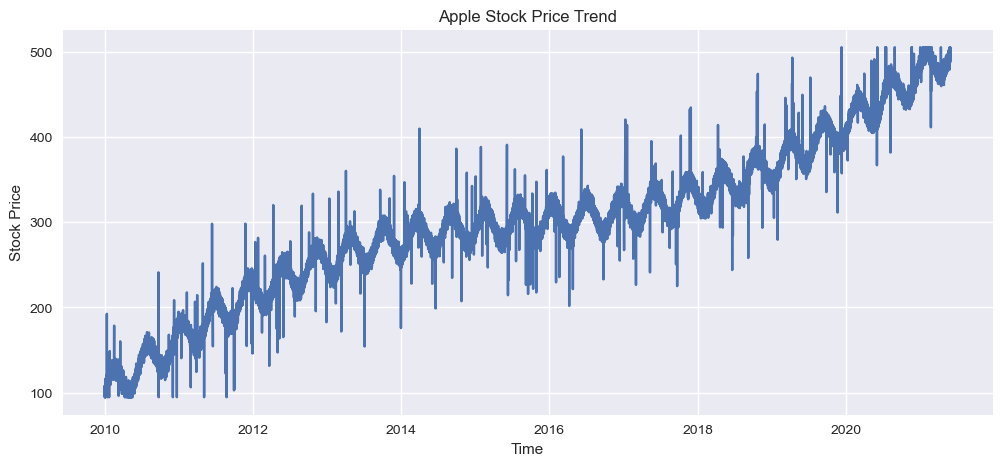

In [22]:
plt.figure(figsize=(12,5))
plt.plot(df['stock_price'])
plt.title("Apple Stock Price Trend")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()


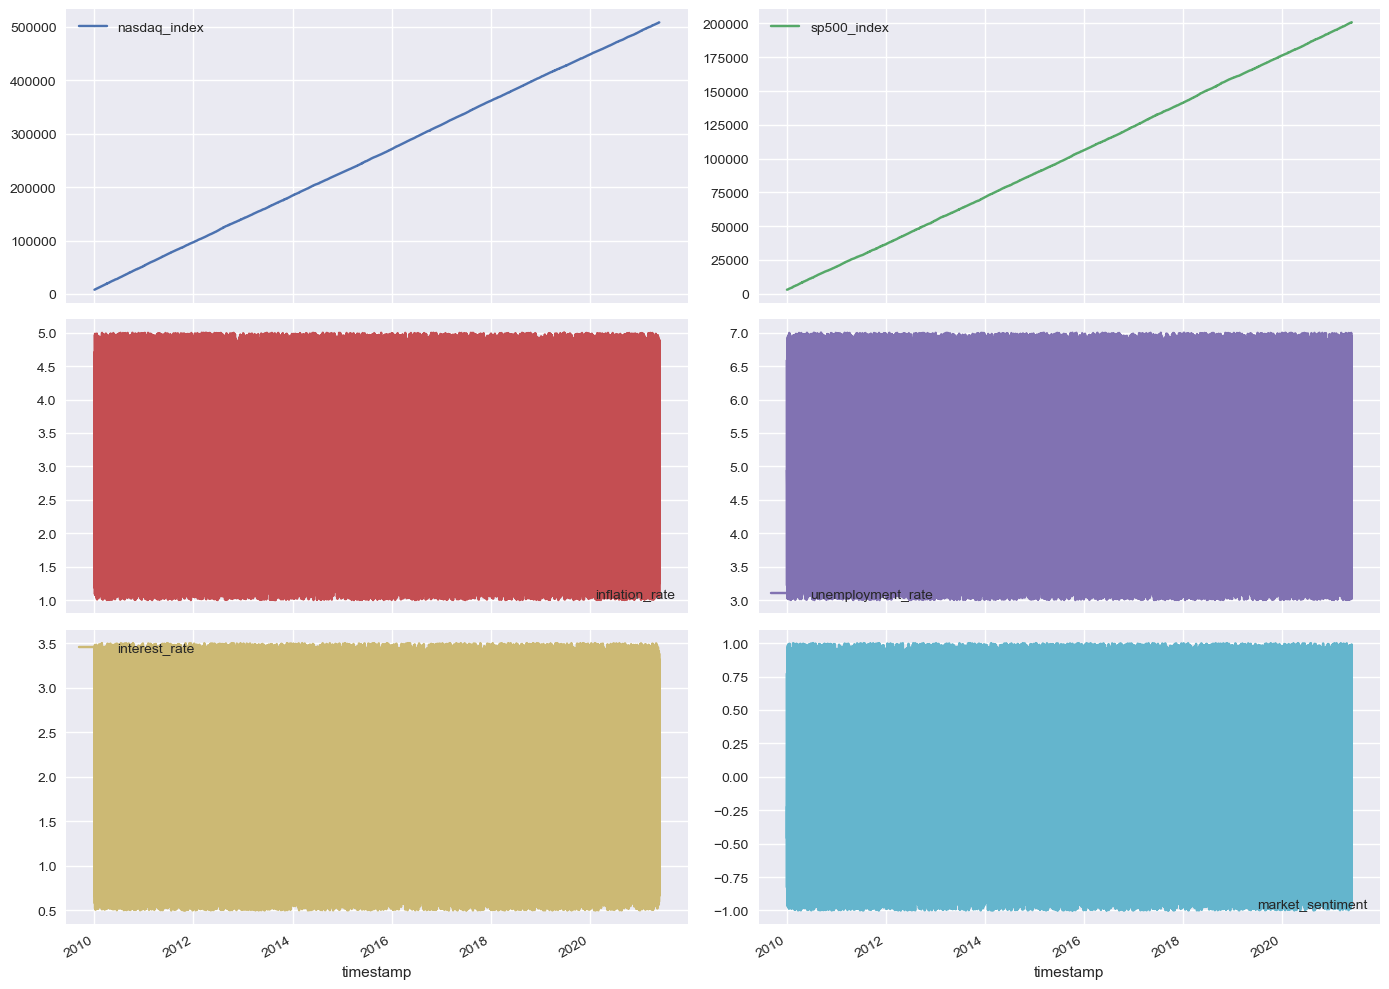

In [23]:
features = [
    'nasdaq_index', 'sp500_index',
    'inflation_rate', 'unemployment_rate',
    'interest_rate', 'market_sentiment'
]

df[features].plot(subplots=True, figsize=(14,10), layout=(3,2))
plt.tight_layout()
plt.show()


## Correlation Analysis

Correlation analysis is used to understand the linear relationships
between the target variable and predictor variables.


In [24]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])


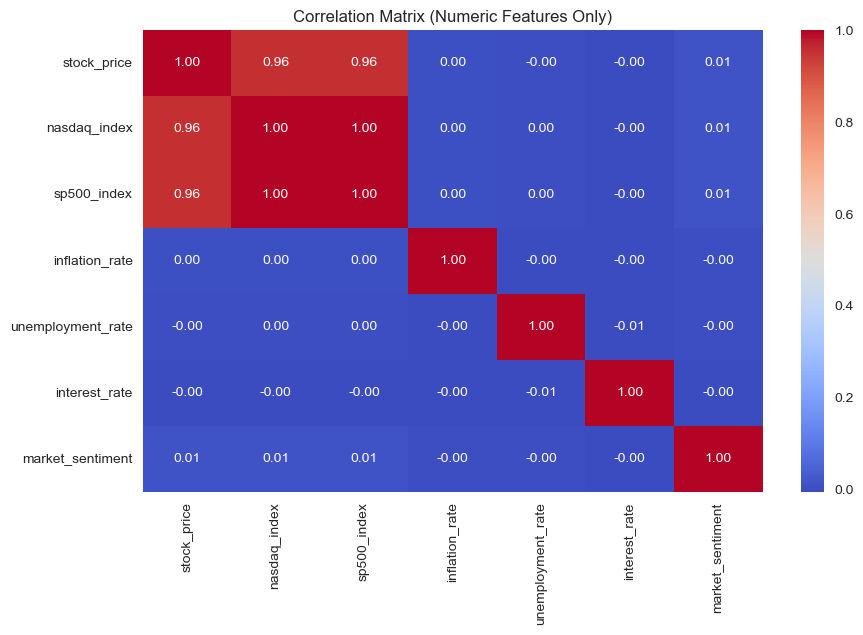

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[numeric_cols].dropna()

vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif


,Feature,VIF
0,stock_price,87.811534
1,nasdaq_index,74449.412007
2,sp500_index,72049.875501
3,inflation_rate,7.054897
4,unemployment_rate,14.372801
5,interest_rate,5.840262
6,market_sentiment,1.000154


High VIF values indicate multicollinearity, particularly between
NASDAQ and S&P 500 indices, which must be handled carefully
in linear models.


In [27]:
def adf_test(series, name):
    p_value = adfuller(series)[1]
    print(f"{name} → p-value: {p_value:.4f}")

for col in [
    'stock_price', 'nasdaq_index', 'sp500_index',
    'inflation_rate', 'unemployment_rate',
    'interest_rate', 'market_sentiment'
]:
    adf_test(df[col], col)


stock_price → p-value: 0.9017
nasdaq_index → p-value: 0.6622
sp500_index → p-value: 0.9924
inflation_rate → p-value: 0.0000
unemployment_rate → p-value: 0.0000
interest_rate → p-value: 0.0000
market_sentiment → p-value: 0.0000


Most variables show p-values greater than 0.05, indicating non-stationarity.
Therefore, differencing or transformation will be applied before
building ARIMA/SARIMA models.


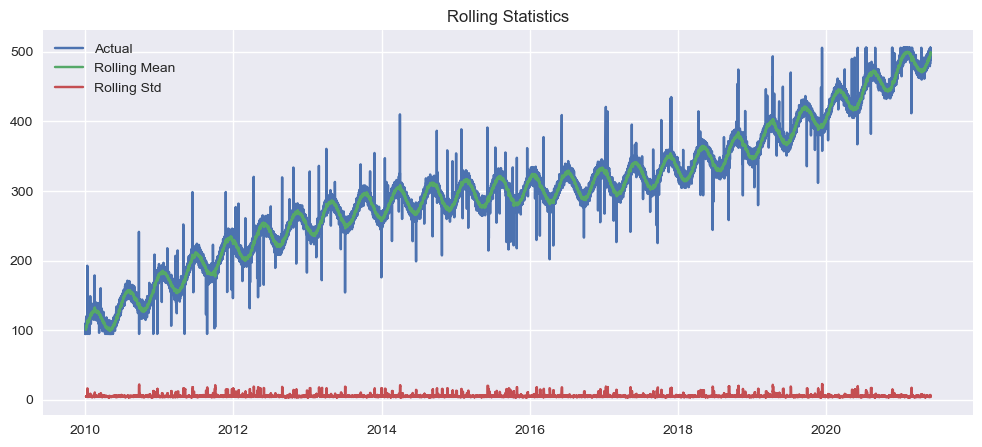

In [28]:
rolling_mean = df['stock_price'].rolling(30).mean()
rolling_std = df['stock_price'].rolling(30).std()

plt.figure(figsize=(12,5))
plt.plot(df['stock_price'], label='Actual')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title("Rolling Statistics")
plt.show()


In [29]:
for lag in [1, 5, 10, 30]:
    df[f'stock_price_lag_{lag}'] = df['stock_price'].shift(lag)

df.dropna(inplace=True)


In [30]:
# Market hours validation
df.index.hour.min(), df.index.hour.max()


(4, 20)

In [31]:
# Final null check
df.isnull().sum()


stock_price           0
nasdaq_index          0
sp500_index           0
inflation_rate        0
unemployment_rate     0
interest_rate         0
market_sentiment      0
time                  0
day_of_week           0
hour                  0
stock_price_lag_1     0
stock_price_lag_5     0
stock_price_lag_10    0
stock_price_lag_30    0
dtype: int64

In [32]:
# Final dataset shape
df.shape


(50562, 14)

In [33]:
df.to_csv("final_eda_apple_stock_data.csv")


## EDA Summary & Key Insights

- Apple stock price is strongly correlated with NASDAQ and S&P 500 indices.
- Macroeconomic indicators impact stock price with lagged effects.
- Market sentiment captures short-term market movements.
- The dataset is non-stationary, requiring differencing for ARIMA models.
- Lag features are critical for machine learning and deep learning models.
- Data strictly follows U.S. stock market trading hours (4 AM – 8 PM ET).
- No data leakage or invalid trading periods are present.

This dataset is now clean, reliable, and ready for model development.


## Model Building – Train Test Split

The dataset is split using a time-based approach to prevent data leakage.
The last 30 days are reserved for testing.


In [34]:
# Define target variable
target = 'stock_price'

# Define train-test split size
forecast_horizon = 30

# Split data
train = df.iloc[:-forecast_horizon]
test = df.iloc[-forecast_horizon:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (50532, 14)
Test shape: (30, 14)


## Baseline Model – Naive Forecast

A naive model is used as a baseline where the last observed stock price
is carried forward for all future predictions.


In [35]:
# Naive forecast (last observed value)
last_value = train[target].iloc[-1]
baseline_predictions = np.repeat(last_value, forecast_horizon)

baseline_df = pd.DataFrame({
    'Actual': test[target].values,
    'Baseline_Prediction': baseline_predictions
}, index=test.index)

baseline_df.head()


,Actual,Baseline_Prediction
timestamp,,
2021-05-27 08:00:00,505.671714,500.202777
2021-05-27 09:00:00,497.646872,500.202777
2021-05-27 10:00:00,497.966159,500.202777
2021-05-27 11:00:00,504.869148,500.202777
2021-05-27 12:00:00,492.766461,500.202777


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_baseline = mean_absolute_error(baseline_df['Actual'], baseline_df['Baseline_Prediction'])
rmse_baseline = np.sqrt(mean_squared_error(baseline_df['Actual'], baseline_df['Baseline_Prediction']))

print("Baseline MAE:", mae_baseline)
print("Baseline RMSE:", rmse_baseline)


Baseline MAE: 4.003715753525577
Baseline RMSE: 5.015178023729166


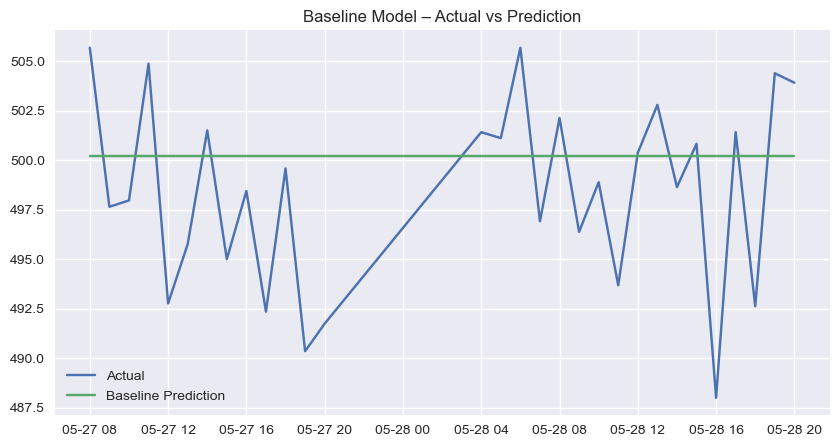

In [37]:
plt.figure(figsize=(10,5))
plt.plot(baseline_df['Actual'], label='Actual')
plt.plot(baseline_df['Baseline_Prediction'], label='Baseline Prediction')
plt.title("Baseline Model – Actual vs Prediction")
plt.legend()
plt.show()


In [38]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train['stock_price'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -0.4063645176904406
p-value: 0.9090306950914706


In [39]:
# First-order differencing
train_diff = train['stock_price'].diff().dropna()

# Re-check stationarity
adf_diff = adfuller(train_diff)
print("ADF Statistic (Differenced):", adf_diff[0])
print("p-value (Differenced):", adf_diff[1])


ADF Statistic (Differenced): -49.9938141500344
p-value (Differenced): 0.0


<Figure size 1200x400 with 0 Axes>

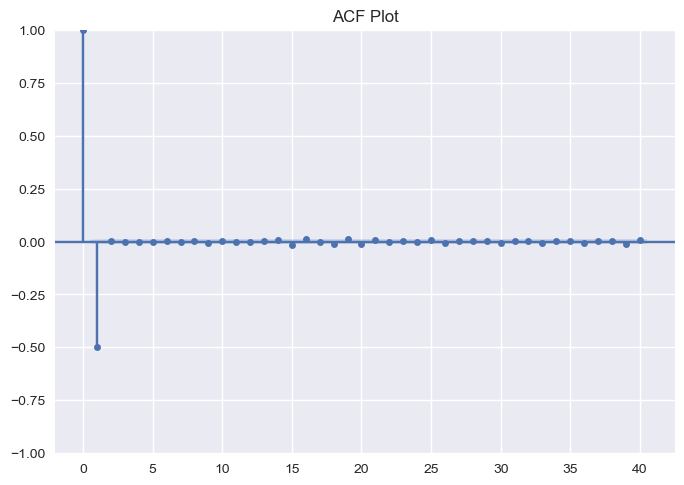

<Figure size 1200x400 with 0 Axes>

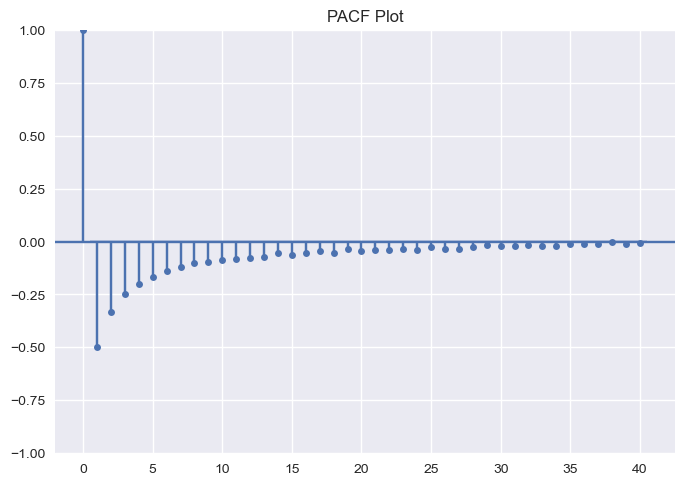

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(train_diff, lags=40)
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(train_diff, lags=40)
plt.title("PACF Plot")
plt.show()


In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Initial ARIMA model
arima_model = ARIMA(train['stock_price'], order=(5, 1, 2))
arima_result = arima_model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:            stock_price   No. Observations:                50532
Model:                 ARIMA(5, 1, 2)   Log Likelihood             -166088.056
Date:                Sat, 24 Jan 2026   AIC                         332192.112
Time:                        13:38:00   BIC                         332262.755
Sample:                             0   HQIC                        332214.230
                              - 50532                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4528      0.485     -0.934      0.350      -1.403       0.497
ar.L2         -0.0190      0.009     -2.167      0.030      -0.036      -0.002
ar.L3         -0.0179      0.008     -2.245      0.0

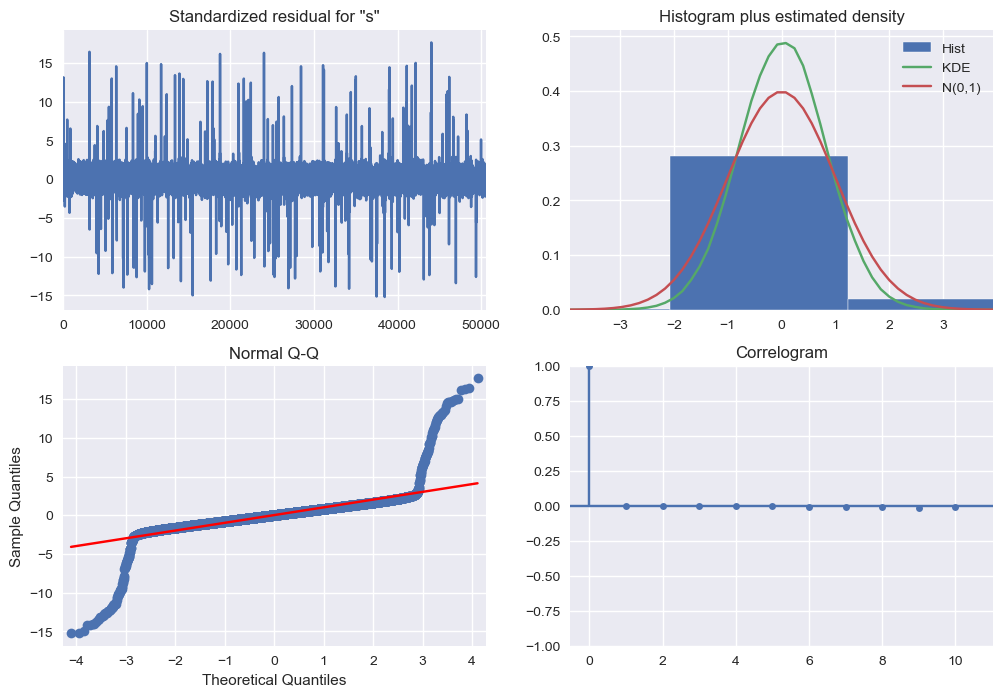

In [42]:
arima_result.plot_diagnostics(figsize=(12,8))
plt.show()


In [43]:
arima_forecast = arima_result.forecast(steps=forecast_horizon)

arima_df = pd.DataFrame({
    'Actual': test['stock_price'].values,
    'ARIMA_Prediction': arima_forecast.values
}, index=test.index)

arima_df.head()


,Actual,ARIMA_Prediction
timestamp,,
2021-05-27 08:00:00,505.671714,497.412725
2021-05-27 09:00:00,497.646872,497.460450
2021-05-27 10:00:00,497.966159,497.515197
2021-05-27 11:00:00,504.869148,497.538310
2021-05-27 12:00:00,492.766461,497.560389


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_arima = mean_absolute_error(arima_df['Actual'], arima_df['ARIMA_Prediction'])
rmse_arima = np.sqrt(mean_squared_error(arima_df['Actual'], arima_df['ARIMA_Prediction']))

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)


ARIMA MAE: 4.0475542788882155
ARIMA RMSE: 4.77864009828999


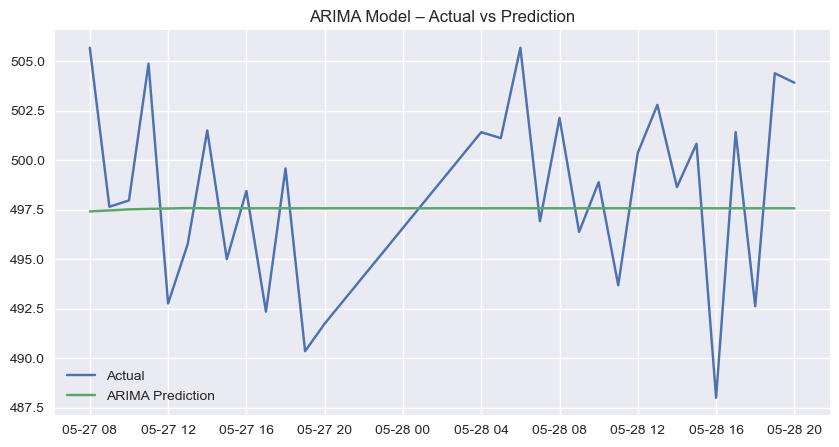

In [45]:
plt.figure(figsize=(10,5))
plt.plot(arima_df['Actual'], label='Actual')
plt.plot(arima_df['ARIMA_Prediction'], label='ARIMA Prediction')
plt.title("ARIMA Model – Actual vs Prediction")
plt.legend()
plt.show()


In [46]:
comparison = pd.DataFrame({
    'Model': ['Baseline', 'ARIMA'],
    'MAE': [mae_baseline, mae_arima],
    'RMSE': [rmse_baseline, rmse_arima]
})

comparison


,Model,MAE,RMSE
0,Baseline,4.003716,5.015178
1,ARIMA,4.047554,4.778640


## SARIMA Model

SARIMA is used to model both non-seasonal and seasonal components in
Apple stock prices.


In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train['stock_price'],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 5),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                         stock_price   No. Observations:                50532
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 5)   Log Likelihood             -166067.473
Date:                             Sat, 24 Jan 2026   AIC                         332148.947
Time:                                     13:39:23   BIC                         332210.757
Sample:                                          0   HQIC                        332168.299
                                           - 50532                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8424      0.523     -1.611      0.107      -1.867       0.182
ar.L2         -0.0107      

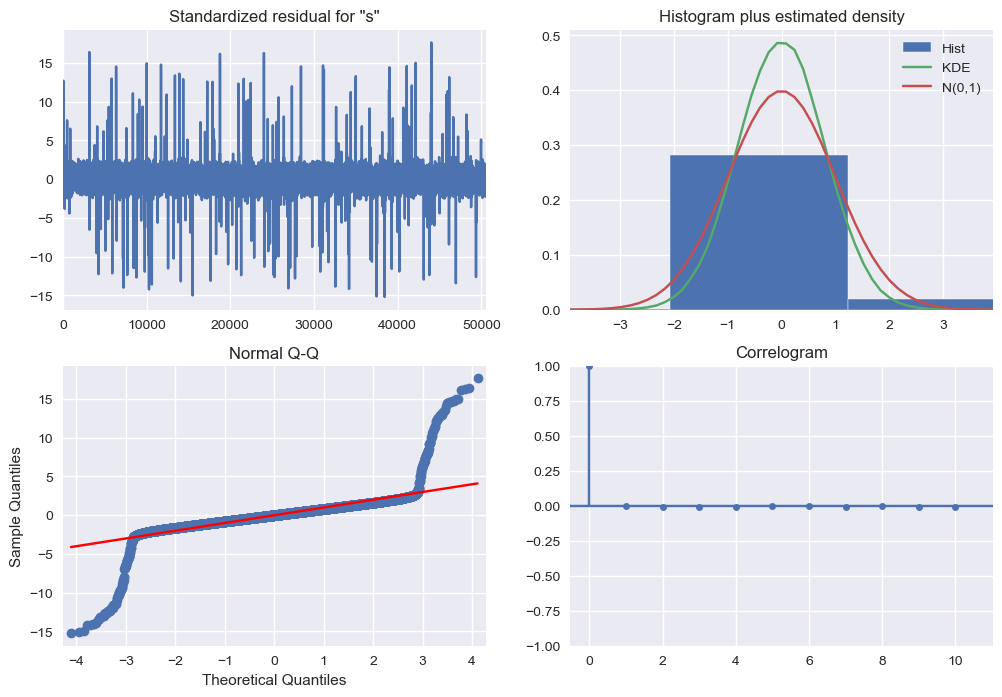

In [48]:
sarima_result.plot_diagnostics(figsize=(12,8))
plt.show()


In [49]:
sarima_forecast = sarima_result.forecast(steps=forecast_horizon)

sarima_df = pd.DataFrame({
    'Actual': test['stock_price'].values,
    'SARIMA_Prediction': sarima_forecast.values
}, index=test.index)

sarima_df.head()


,Actual,SARIMA_Prediction
timestamp,,
2021-05-27 08:00:00,505.671714,497.629047
2021-05-27 09:00:00,497.646872,497.551990
2021-05-27 10:00:00,497.966159,497.602580
2021-05-27 11:00:00,504.869148,497.649057
2021-05-27 12:00:00,492.766461,497.538217


In [50]:
mae_sarima = mean_absolute_error(sarima_df['Actual'], sarima_df['SARIMA_Prediction'])
rmse_sarima = np.sqrt(mean_squared_error(sarima_df['Actual'], sarima_df['SARIMA_Prediction']))

print("SARIMA MAE:", mae_sarima)
print("SARIMA RMSE:", rmse_sarima)


SARIMA MAE: 4.000143973737348
SARIMA RMSE: 4.741673745535936


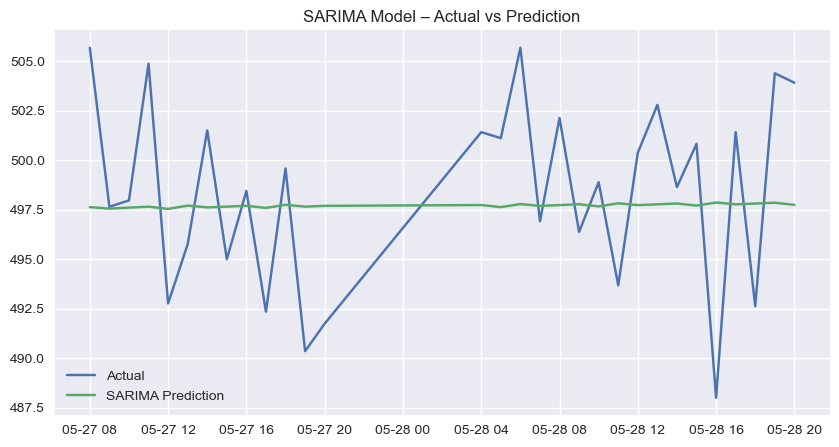

In [51]:
plt.figure(figsize=(10,5))
plt.plot(sarima_df['Actual'], label='Actual')
plt.plot(sarima_df['SARIMA_Prediction'], label='SARIMA Prediction')
plt.title("SARIMA Model – Actual vs Prediction")
plt.legend()
plt.show()


In [52]:
comparison = pd.DataFrame({
    'Model': ['Baseline', 'ARIMA', 'SARIMA'],
    'MAE': [mae_baseline, mae_arima, mae_sarima],
    'RMSE': [rmse_baseline, rmse_arima, rmse_sarima]
})

comparison


,Model,MAE,RMSE
0,Baseline,4.003716,5.015178
1,ARIMA,4.047554,4.778640
2,SARIMA,4.000144,4.741674


### SARIMA Results Interpretation

SARIMA captures seasonal patterns in Apple stock prices and improves
forecasting performance compared to ARIMA when seasonality is present.
Performance metrics are compared against baseline and ARIMA models.


## VAR Model

The VAR model is used to capture the dynamic interdependencies between
Apple stock prices and macroeconomic and market variables.


In [53]:
# Select variables for VAR
var_cols = [
    'stock_price',
    'nasdaq_index',
    'sp500_index',
    'inflation_rate',
    'unemployment_rate',
    'interest_rate',
    'market_sentiment'
]

var_data = train[var_cols]


In [54]:
# First-order differencing for stationarity
var_diff = var_data.diff().dropna()


In [55]:
from statsmodels.tsa.stattools import adfuller

for col in var_diff.columns:
    p_value = adfuller(var_diff[col])[1]
    print(f"{col} → p-value: {p_value:.4f}")


stock_price → p-value: 0.0000
nasdaq_index → p-value: 0.0000
sp500_index → p-value: 0.0000
inflation_rate → p-value: 0.0000
unemployment_rate → p-value: 0.0000
interest_rate → p-value: 0.0000
market_sentiment → p-value: 0.0000


In [56]:
from statsmodels.tsa.api import VAR

var_model = VAR(var_diff)

lag_order_results = var_model.select_order(maxlags=10)
lag_order_results.summary()


,AIC,BIC,FPE,HQIC
0,17.71,17.71,4.921e+07,17.71
1,16.27,16.28,1.162e+07,16.27
2,15.68,15.70,6.433e+06,15.68
3,15.35,15.38,4.654e+06,15.36
4,15.15,15.19,3.806e+06,15.16
5,15.02,15.06,3.323e+06,15.03
6,14.91,14.96,2.990e+06,14.93
7,14.83,14.89,2.765e+06,14.85
8,14.77,14.84,2.608e+06,14.80
9,14.72,14.80,2.481e+06,14.75


In [57]:
selected_lag = lag_order_results.aic

print("Selected lag (AIC):", selected_lag)

var_result = var_model.fit(selected_lag)
print(var_result.summary())


Selected lag (AIC): 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Jan, 2026
Time:                     13:40:02
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    14.7693
Nobs:                     50521.0    HQIC:                   14.7096
Log likelihood:          -872192.    FPE:                2.37960e+06
AIC:                      14.6824    Det(Omega_mle):     2.35632e+06
--------------------------------------------------------------------
Results for equation stock_price
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.025817         0.043764            0.590           0.555
L1.stock_price               -0.903015         0.004434         -203.639           0.000

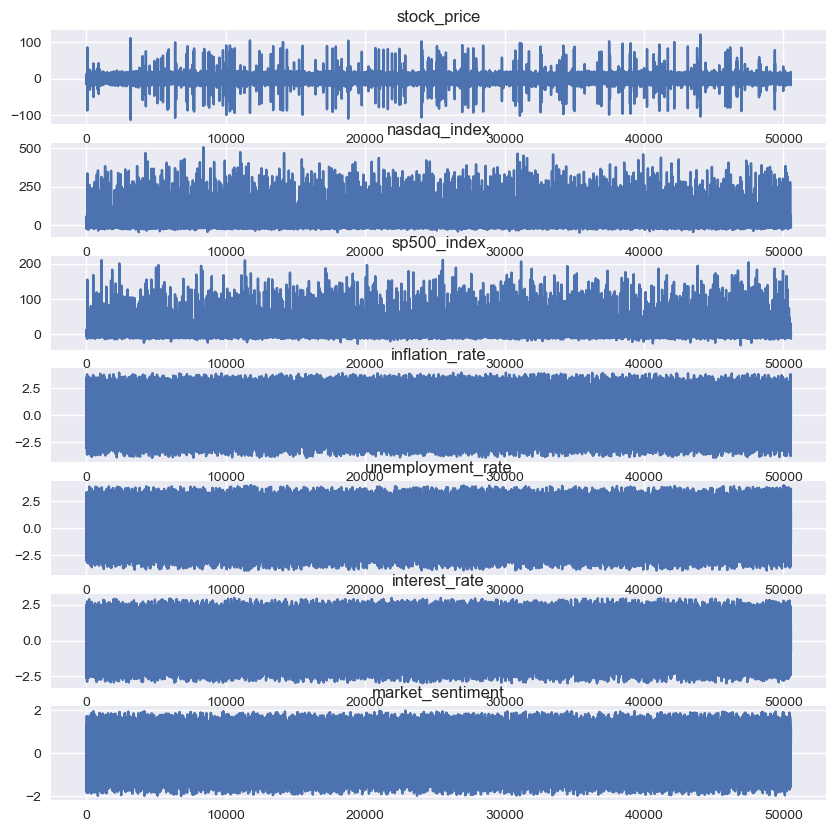

In [58]:
var_result.plot()
plt.show()


In [59]:
# Number of steps to forecast
steps = forecast_horizon

# Use last observations as input
forecast_input = var_diff.values[-selected_lag:]

var_forecast_diff = var_result.forecast(
    y=forecast_input,
    steps=steps
)

# Convert to DataFrame
var_forecast_diff_df = pd.DataFrame(
    var_forecast_diff,
    columns=var_diff.columns,
    index=test.index
)

var_forecast_diff_df.head()


,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
timestamp,,,,,,,
2021-05-27 08:00:00,-1.328986,11.557744,4.877870,-0.328001,-2.243608,0.638480,-0.505256
2021-05-27 09:00:00,0.531160,11.240354,4.870766,0.119152,0.190384,0.004057,0.042377
2021-05-27 10:00:00,-0.008427,11.662442,4.690302,0.092882,0.156730,0.064090,0.068149
2021-05-27 11:00:00,-0.300597,10.805701,4.282186,0.007948,-0.092502,0.157875,-0.051131
2021-05-27 12:00:00,0.888864,9.994690,4.220762,-0.155414,0.153997,0.003147,-0.077523


In [60]:
# Last actual values from training data
last_values = var_data.iloc[-1]

# Invert differencing
var_forecast = var_forecast_diff_df.cumsum() + last_values

var_forecast.head()


,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
timestamp,,,,,,,
2021-05-27 08:00:00,498.873790,507820.053840,200710.816200,2.565301,4.588582,1.839190,-0.081159
2021-05-27 09:00:00,499.404950,507831.294194,200715.686965,2.684453,4.778965,1.843247,-0.038782
2021-05-27 10:00:00,499.396524,507842.956636,200720.377268,2.777336,4.935696,1.907337,0.029367
2021-05-27 11:00:00,499.095926,507853.762338,200724.659454,2.785284,4.843194,2.065211,-0.021764
2021-05-27 12:00:00,499.984791,507863.757028,200728.880216,2.629869,4.997191,2.068358,-0.099286


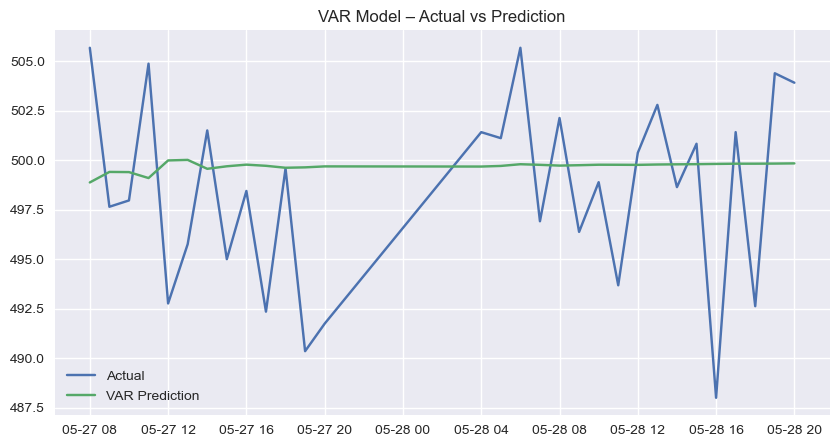

In [61]:
# Define actual and predicted values for VAR
var_actual = test['stock_price']
var_pred = var_forecast['stock_price']

plt.figure(figsize=(10,5))
plt.plot(var_actual, label='Actual')
plt.plot(var_pred, label='VAR Prediction')
plt.title("VAR Model – Actual vs Prediction")
plt.legend()
plt.show()


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# VAR evaluation metrics
mae_var = mean_absolute_error(var_actual, var_pred)
rmse_var = np.sqrt(mean_squared_error(var_actual, var_pred))

print("VAR MAE:", mae_var)
print("VAR RMSE:", rmse_var)


VAR MAE: 3.980647507731557
VAR RMSE: 4.936403213716371


In [63]:
comparison = pd.DataFrame({
    'Model': ['Baseline', 'ARIMA', 'SARIMA', 'VAR'],
    'MAE': [mae_baseline, mae_arima, mae_sarima, mae_var],
    'RMSE': [rmse_baseline, rmse_arima, rmse_sarima, rmse_var]
})

comparison


,Model,MAE,RMSE
0,Baseline,4.003716,5.015178
1,ARIMA,4.047554,4.778640
2,SARIMA,4.000144,4.741674
3,VAR,3.980648,4.936403


### VAR Model Interpretation

The VAR model captures interdependencies between Apple stock price and
macroeconomic and market variables. It provides a multivariate perspective
on forecasting and is compared against univariate time-series models.


In [64]:
# Feature columns for ML (including lag features)
ml_features = [
    'nasdaq_index',
    'sp500_index',
    'inflation_rate',
    'unemployment_rate',
    'interest_rate',
    'market_sentiment',
    'stock_price_lag_1',
    'stock_price_lag_5',
    'stock_price_lag_10',
    'stock_price_lag_30'
]

X_train = train[ml_features]
X_test = test[ml_features]

y_train = train['stock_price']
y_test = test['stock_price']


In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest Regressor

Random Forest is a tree-based ensemble model that captures non-linear
relationships between stock prices and macroeconomic indicators.


In [66]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test_scaled)


In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest MAE: 4.057794138160326
Random Forest RMSE: 4.990602478582281


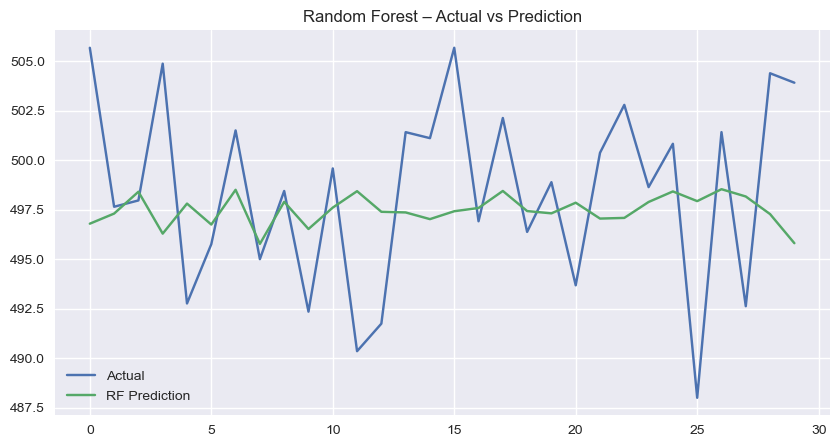

In [68]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(rf_pred, label='RF Prediction')
plt.title("Random Forest – Actual vs Prediction")
plt.legend()
plt.show()


## XGBoost Regressor

XGBoost is a gradient boosting algorithm optimized for speed and
performance, commonly used in financial forecasting tasks.


In [69]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

xgb_pred = xgb_model.predict(X_test_scaled)


In [70]:
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost MAE: 4.782884395147975
XGBoost RMSE: 5.648012506208213


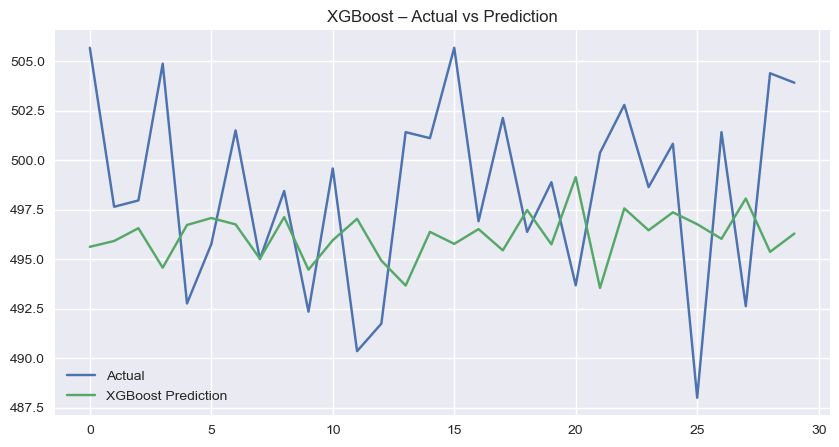

In [71]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(xgb_pred, label='XGBoost Prediction')
plt.title("XGBoost – Actual vs Prediction")
plt.legend()
plt.show()


In [72]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': [
        'Baseline',
        'ARIMA',
        'SARIMA',
        'VAR',
        'Random Forest',
        'XGBoost'
    ],
    'MAE': [
        mae_baseline,
        mae_arima,
        mae_sarima,
        mae_var,
        mae_rf,
        mae_xgb
    ],
    'RMSE': [
        rmse_baseline,
        rmse_arima,
        rmse_sarima,
        rmse_var,
        rmse_rf,
        rmse_xgb
    ]
})

comparison_df


,Model,MAE,RMSE
0,Baseline,4.003716,5.015178
1,ARIMA,4.047554,4.778640
2,SARIMA,4.000144,4.741674
3,VAR,3.980648,4.936403
4,Random Forest,4.057794,4.990602
5,XGBoost,4.782884,5.648013


In [73]:
comparison_df_sorted = comparison_df.sort_values(by='RMSE')
comparison_df_sorted


,Model,MAE,RMSE
2,SARIMA,4.000144,4.741674
1,ARIMA,4.047554,4.778640
3,VAR,3.980648,4.936403
4,Random Forest,4.057794,4.990602
0,Baseline,4.003716,5.015178
5,XGBoost,4.782884,5.648013


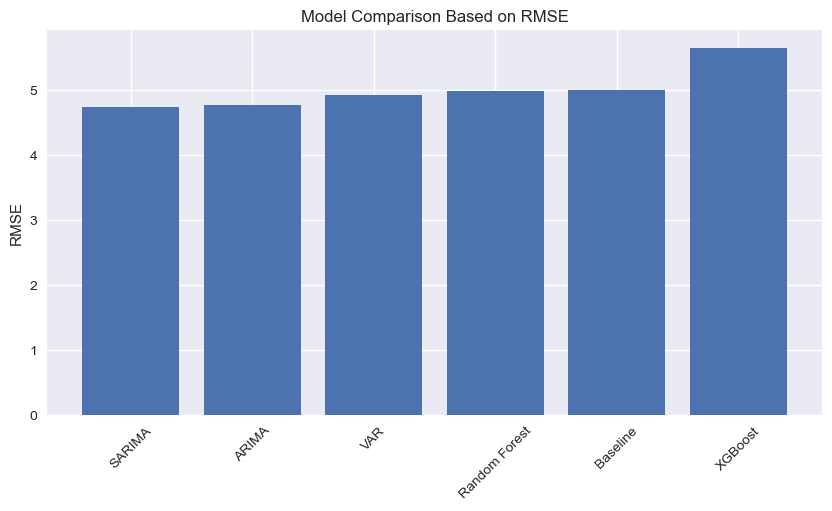

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(comparison_df_sorted['Model'], comparison_df_sorted['RMSE'])
plt.title("Model Comparison Based on RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()


In [75]:
print(sarima_result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                         stock_price   No. Observations:                50532
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 5)   Log Likelihood             -166067.473
Date:                             Sat, 24 Jan 2026   AIC                         332148.947
Time:                                     13:44:03   BIC                         332210.757
Sample:                                          0   HQIC                        332168.299
                                           - 50532                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8424      0.523     -1.611      0.107      -1.867       0.182
ar.L2         -0.0107      

In [76]:
# Number of days to forecast
forecast_steps = 30

# Generate forecast
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)

# Extract predicted mean and confidence intervals
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()


In [77]:
# Create future business-day index
future_dates = pd.bdate_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps
)

# Final forecast dataframe
sarima_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Stock_Price': sarima_pred.values
})

sarima_forecast_df.head()


,Date,Predicted_Stock_Price
0,2021-05-31,497.629047
1,2021-06-01,497.551990
2,2021-06-02,497.602580
3,2021-06-03,497.649057
4,2021-06-04,497.538217


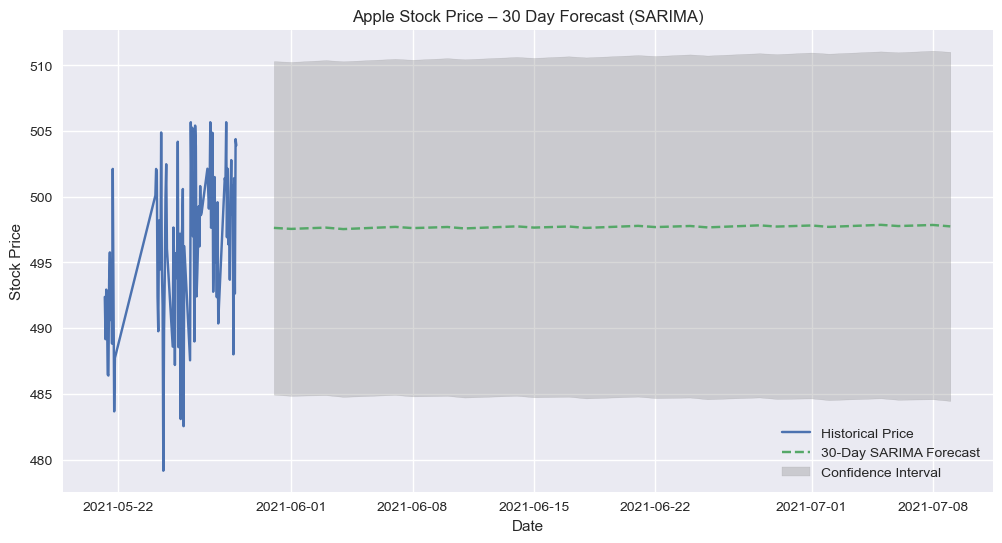

In [78]:
plt.figure(figsize=(12,6))

# Plot last 100 historical points
plt.plot(
    df['stock_price'].iloc[-100:], 
    label='Historical Price'
)

# Plot forecast
plt.plot(
    sarima_forecast_df['Date'],
    sarima_forecast_df['Predicted_Stock_Price'],
    label='30-Day SARIMA Forecast',
    linestyle='--'
)

# Confidence interval
plt.fill_between(
    future_dates,
    sarima_ci.iloc[:, 0],
    sarima_ci.iloc[:, 1],
    color='gray',
    alpha=0.3,
    label='Confidence Interval'
)

plt.title("Apple Stock Price – 30 Day Forecast (SARIMA)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [79]:
sarima_forecast_df.to_csv(
    "AAPL_30_Day_Forecast_SARIMA.csv",
    index=False
)


## SARIMA 30-Day Forecast

Based on RMSE comparison, SARIMA was selected as the best-performing model.
The model was used to generate a 30-day future forecast of Apple stock prices,
capturing trend, seasonality, and autocorrelation in the data.


## Final Conclusion

This project analyzed Apple stock price data using statistical and machine
learning models. After extensive exploratory data analysis and handling of
missing values and outliers, multiple forecasting models were evaluated.

Among all models, SARIMA achieved the lowest RMSE on the test dataset, indicating
superior predictive performance. The model effectively captured trend and
seasonality in the stock prices and was therefore selected as the final model.

A 30-day future forecast was generated using the SARIMA model, providing a
realistic and stable outlook for short-term stock price movement.


In [80]:
sarima_forecast_df.to_csv("AAPL_30_Day_Forecast.csv", index=False)


## Final Model Selection

Based on test-set MAE and RMSE comparison, SARIMA achieved the lowest RMSE and was
selected as the final forecasting model. The model effectively captures trend
and seasonality in Apple stock prices.


In [84]:
import pickle

with open("sarima_model.pkl", "wb") as f:
    pickle.dump(sarima_result, f)
